In [1]:
#!pip install yfinance --upgrade --no-cache-dir

In [2]:
#!pip3 install pandas_datareader      Had to do some installs.

# RSI ML Predictive Model
<p> In this experiment, the team decided to use the RSI to train a predictive model 
    in hopes of identifying entry and exit points to AAPL stock or preemptive buy and sell oportunities.</p>

### STEP 1: 
<p>Learning Which Libraires help make the project better. Messy but it was learn as you go.</p>

In [2]:
# Wanted to play with HTML 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_imports___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

# more imports only sepreated bc I didnt know what I needed so I modified as I went along
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API - used to pull data
import yfinance as yahoo_finance

#optional - dont know what this does....yet
#yahoo_finance.pdr_override()

%matplotlib inline

In [3]:
# Pick your STOCK Ticker
ticker = 'AAPL'

# you can modify time for dataset import here:
start_time = datetime.datetime(2017, 10, 1)

# and here: end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat() 

# The reason we do not pull YTD is because when you back test, you will predict for a day in the near future. 
# That is, for a day in our human past but in the machines algorythmic future, and analyze if the prediction is accurate or not.
# because you human, already know what the stock price is bc its in your past and you can check. 
# But the machine doesnt know what "time" it is in therefore it "thinks" its predicting the future. Get it?

In [4]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date to work with the dataframe     
ticker_df = ticker_df.reset_index()
ticker_df.head(5)

connected to yahoo


,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-10-02,38.612499,38.180000,38.564999,38.452499,74795200.0,36.753414
1,2017-10-03,38.772499,38.477501,38.502499,38.619999,64921200.0,36.913517
2,2017-10-04,38.465000,38.115002,38.407501,38.369999,80655200.0,36.674561
3,2017-10-05,38.860001,38.512501,38.544998,38.847500,85135200.0,37.130966
4,2017-10-06,38.872501,38.639999,38.742500,38.825001,69630400.0,37.109447


In [5]:
# Made a csv file for JERRY
ticker_df.to_csv('AAPLforSTACK.csv')

In [6]:
# Set a Variable for Dataframe
df = ticker_df

# TRADING STRATEGIES 
<p> Trading strategies are developed by analyzing technical indicators. There are several. For this team project RSI was selected as the preffered signal. My model for predictive price projections is based on this trading strategy. NO ONE CAN PREDICT THE MARKET ALL MY MODELS FAILED. NOT TRADING ADVICE. </p>

# RSI 
<p> Buying and selling stock with RSI. How do you buy and sell with RSI indicator?
The RSI is a technical analysis momentum indicator which displays a number from zero to 100. Any level below 30 is oversold, while an RSI of over 70 suggests the shares are overbought. Thus, if AAPL has an RSI of 25, you can assume that the shares are very likely to rise from current levels. (investopedia)</p>

In [7]:
# ok Here we go, computing indicators, teams asked for RSI but I think this is the wrong indicator.....for predictions:
# RSI indicates changes in price and that doesnt necessarily increase profit margins. Also making all the data into the same timefram
# 5 days, will severly overfit the ML...but the team wants 5 days; nevere the less 
# Buying and selling to often can errod profits quickly and not a great strategy. But the team wants RSI so here it is:

def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values. if up then buy, if down then sell, basically
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [8]:
# RSI is computed traditionally with 14 days. You may change the No.14 in the command code to reflect 
# your desired computation. The team had several dates they wanted to explore. This one line of 
# Code should make changes simple for each team members needs.
df['RSI'] = computeRSI(df['Adj Close'], 14)

In [9]:
# Display the Data
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,RSI
0,2017-10-02,38.612499,38.180000,38.564999,38.452499,74795200.0,36.753414,NaN
1,2017-10-03,38.772499,38.477501,38.502499,38.619999,64921200.0,36.913517,NaN
2,2017-10-04,38.465000,38.115002,38.407501,38.369999,80655200.0,36.674561,NaN
3,2017-10-05,38.860001,38.512501,38.544998,38.847500,85135200.0,37.130966,NaN
4,2017-10-06,38.872501,38.639999,38.742500,38.825001,69630400.0,37.109447,NaN


In [10]:
# Dispaly the end of the data bc we see lots of NaN values. DO NOT REMOVE, as they will shrink your data set.
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,RSI
963,2021-07-30,146.330002,144.110001,144.380005,145.860001,70382000.0,145.860001,58.328639
964,2021-08-02,146.949997,145.250000,146.360001,145.520004,62880000.0,145.520004,57.324905
965,2021-08-03,148.039993,145.179993,145.809998,147.360001,64660800.0,147.360001,61.214738
966,2021-08-04,147.789993,146.279999,147.270004,146.949997,56368300.0,146.949997,59.904438
967,2021-08-05,147.839996,146.169998,146.979996,147.059998,46343200.0,147.059998,60.150886


In [11]:
# CALCULATE EMA change the No. 14 and we can adjust to fit the needs of each team members model.
df['ema-5'] = df['Adj Close'].ewm(com=14-1 , min_periods=14).mean()

In [12]:
# Display the Data 
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,RSI,ema-5
0,2017-10-02,38.612499,38.180000,38.564999,38.452499,74795200.0,36.753414,NaN,NaN
1,2017-10-03,38.772499,38.477501,38.502499,38.619999,64921200.0,36.913517,NaN,NaN
2,2017-10-04,38.465000,38.115002,38.407501,38.369999,80655200.0,36.674561,NaN,NaN
3,2017-10-05,38.860001,38.512501,38.544998,38.847500,85135200.0,37.130966,NaN,NaN
4,2017-10-06,38.872501,38.639999,38.742500,38.825001,69630400.0,37.109447,NaN,NaN


In [13]:
# EMA = EWA Indicator its the same thing from R except the m is upsidedown in this language, idky.
df['EWA-5'] = df['Adj Close'].rolling(window=120).mean()

In [14]:
# CSV FOR JERRY
df.to_csv('EMA.csv')

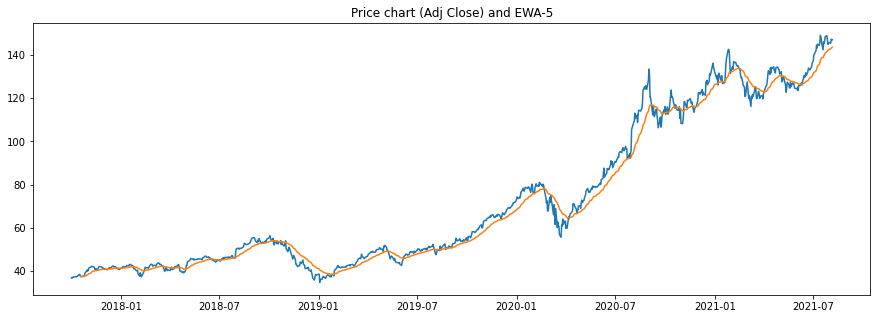

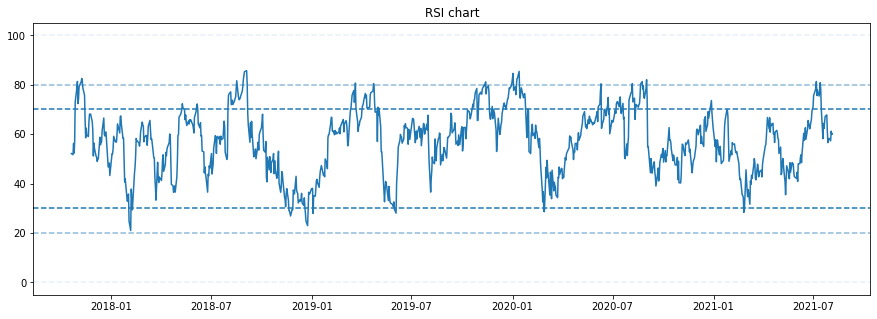

In [15]:
# plot price for fancy visuals !!(>_<)!! 
# Graph Size 
plt.figure(figsize=(15,5))

# x and y axisessss
plt.plot(df['Date'], df['Adj Close'])

# plt.plot(df['Date'], df['SMA-5'])
# EMA or in Python, EWA, is ploted on graph over stock price
plt.plot(df['Date'], df['ema-5'])
plt.title('Price chart (Adj Close) and EWA-5')
plt.show()


# plot corresponding RSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.plot(df['Date'], df['RSI'])

# THESE are the dash lines just to help in the presentation
plt.axhline(0, linestyle='--', alpha=0.1)
plt.axhline(20, linestyle='--', alpha=0.5)
plt.axhline(30, linestyle='--')

plt.axhline(70, linestyle='--')
plt.axhline(80, linestyle='--', alpha=0.5)
plt.axhline(100, linestyle='--', alpha=0.1)
plt.show()

# ANALYZE RSI INDICATOR 
<p> When RSI hits a target point, traditionally 70/30 (in the graphs case 80/20), it is an indication that a price change is imminent. Which could be a great buy/sell indicator. However, simply trading based one one signal can quickly erode profit margins because every trade comes with a transactional cost. Lets pull other indicators and see what they do:</p>

# Moving Average Convergence Divergence (MACD)
<p> An MACD indicator is that shows the relative change between 2 moving averages; long(26 day) and short (12 day) (Technical Analysis with R). In essence The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period average EMA(investopedia). Where RSI signals an Overbought or Oversold condition, MACD is the momentum or the degree of market movement momentum when buying or selling.</p>

In [16]:
# Pull AAPL Ticker 
ticker = 'AAPL'

In [17]:
# tcoil stock code: Pull ticker like before
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()

# Display data
print(ticker_df.head(5))

connected to yahoo
        Date       High        Low       Open      Close      Volume  Adj Close
0 2017-10-02  38.612499  38.180000  38.564999  38.452499  74795200.0  36.753414
1 2017-10-03  38.772499  38.477501  38.502499  38.619999  64921200.0  36.913517
2 2017-10-04  38.465000  38.115002  38.407501  38.369999  80655200.0  36.674561
3 2017-10-05  38.860001  38.512501  38.544998  38.847500  85135200.0  37.130966
4 2017-10-06  38.872501  38.639999  38.742500  38.825001  69630400.0  37.109447


<p> NOTE: <li>I AM REWRITING THIS CODE BC I dont want my team to scroll all the way to the top to understand how we created this computation. 
Yes, this is redudant BUT bc this is a learning excersis and my teammates are all at differeng levels of understanding I am OPTING, for the sake of those like me who are super noobs, to do it this way.
I accept the deductions in grading for the redundancies in hopes of saving my teammates from uncontrollable caffinated emotional breakdowns with these gawd aweful models that are destined to fail. </p>

In [18]:
# user defined variable for 
df = ticker_df

In [19]:
# MACD Computational code 
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Adj Close']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    MACDhist = pd.Series(MACD - MACDsig, name = 'MACDhist')
    df = df.join(MACD)
    df = df.join(MACDsig)
    df = df.join(MACDhist)
    
    return df

In [20]:
# MACD Computation periods whic can be changed by other team mates to meet their models needs
df = computeMACD(df, 12, 26, 9)

In [21]:
print(df.head())
print(df.tail())

        Date       High        Low       Open      Close      Volume  Adj Close  MACD  MACDsig  MACDhist
0 2017-10-02  38.612499  38.180000  38.564999  38.452499  74795200.0  36.753414   NaN      NaN       NaN
1 2017-10-03  38.772499  38.477501  38.502499  38.619999  64921200.0  36.913517   NaN      NaN       NaN
2 2017-10-04  38.465000  38.115002  38.407501  38.369999  80655200.0  36.674561   NaN      NaN       NaN
3 2017-10-05  38.860001  38.512501  38.544998  38.847500  85135200.0  37.130966   NaN      NaN       NaN
4 2017-10-06  38.872501  38.639999  38.742500  38.825001  69630400.0  37.109447   NaN      NaN       NaN
          Date        High         Low        Open       Close      Volume   Adj Close      MACD   MACDsig  MACDhist
963 2021-07-30  146.330002  144.110001  144.380005  145.860001  70382000.0  145.860001  2.912130  3.549156 -0.637026
964 2021-08-02  146.949997  145.250000  146.360001  145.520004  62880000.0  145.520004  2.677710  3.374866 -0.697156
965 2021-08-03  148

In [22]:
# Now lets save the csv for Jerry bc he will ask for it instead of looking at my code (*_*)
df.to_csv('MACD.csv')

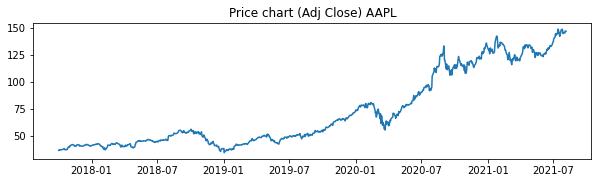

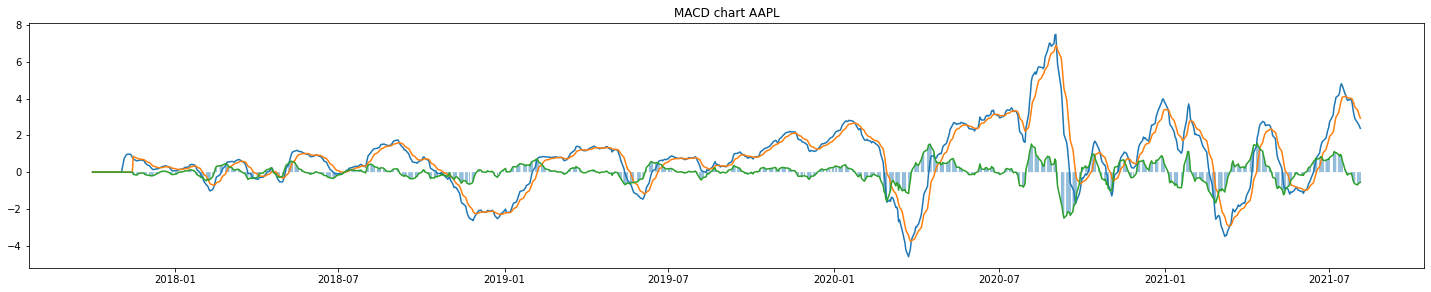

In [23]:
# Lets make visualzzzzz

# plot price
plt.figure(figsize=(10,2.5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()

# plot correspondingRSI values and significant levels
# Increase graph for MACD long short divergence on figsize in the following code commands:
plt.figure(figsize=(25,4.5))

# just graphing and line colors
plt.title('MACD chart ' + str(ticker))
plt.plot(df['Date'], df['MACD'].fillna(0))
plt.plot(df['Date'], df['MACDsig'].fillna(0))
plt.plot(df['Date'], df['MACDhist'].fillna(0))
plt.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False)

plt.show()

# ANALYZE MACD INDICATOR
<p> The MACD's popularity is largely due to its ability to help quickly spot increasing short-term momentum. As you can see from the chart above, "many traders will watch for a short-term moving average (blue line; 12 day) to cross above a longer-term moving average (orange line, 26 day) and use this to signal increasing upward momentum aka LARGER PROFIT MARGINS (Market Wizards).</p> <li><p>This bullish crossover suggests that the price has recently been rising at a faster rate than it has in the past, so it is a common technical buy sign. Conversely, a short-term moving average crossing below a longer-term average is used to illustrate that the asset's price has been moving downward at a faster rate and that it may be a good time to sell." (investopedia)</p><li>
<p>As the short and long EMA's move away from each other as profit margins increase therefore MACD would be a better indicator for profitability than RSI. This is gold for model accuracy training!</p> 

# CREATING BUY SELL SIGNALS 

In [25]:
#signalling algorithm modified from
#https://www.youtube.com/watch?v=kz_NJERCgm8&t=493s&ab_channel=ComputerScience

def generate_signals(df):
    buy_list = []
    sell_list = []
    flag = -1
    
    for i in range(0,len(df)):
        if df['MACD'][i] > df['MACDsig'][i]:         # first occurence of MACD crossing above signal line
            sell_list.append(np.nan)                 # so first flip above means buy
            if flag != 1:                            # after first occurence I record flip to ignore
                buy_list.append(df['Close'][i])      # from here onwards
                flag = 1
            else:
                buy_list.append(np.nan)
        elif df['MACD'][i] < df['MACDsig'][i]:
            buy_list.append(np.nan)
            if flag != 0:
                sell_list.append(df['Close'][i])
                flag = 0
            else:
                sell_list.append(np.nan)
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list, sell_list)            


# create buy and sell column
signal = generate_signals(df)
df['buy_sig'] = signal[0]
df['sell_sig'] = signal[1]







In [59]:
#display data
df

,Date,High,Low,Open,Close,Volume,Adj Close,MACD,MACDsig,MACDhist,buy_sig,sell_sig
0,2017-10-02,38.612499,38.180000,38.564999,38.452499,74795200.0,36.753414,NaN,NaN,NaN,NaN,NaN
1,2017-10-03,38.772499,38.477501,38.502499,38.619999,64921200.0,36.913517,NaN,NaN,NaN,NaN,NaN
2,2017-10-04,38.465000,38.115002,38.407501,38.369999,80655200.0,36.674561,NaN,NaN,NaN,NaN,NaN
3,2017-10-05,38.860001,38.512501,38.544998,38.847500,85135200.0,37.130966,NaN,NaN,NaN,NaN,NaN
4,2017-10-06,38.872501,38.639999,38.742500,38.825001,69630400.0,37.109447,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
963,2021-07-30,146.330002,144.110001,144.380005,145.860001,70382000.0,145.860001,2.912130,3.549156,-0.637026,NaN,NaN
964,2021-08-02,146.949997,145.250000,146.360001,145.520004,62880000.0,145.520004,2.677710,3.374866,-0.697156,NaN,NaN
965,2021-08-03,148.039993,145.179993,145.809998,147.360001,64660800.0,147.360001,2.610313,3.221956,-0.611643,NaN,NaN
966,2021-08-04,147.789993,146.279999,147.270004,146.949997,56319800.0,146.949997,2.495055,3.076576,-0.581521,NaN,NaN


In [60]:
# MORE VISUALZ 
def plot_signals(df, ticker):
    # plot price
    plt.figure(figsize=(15,5))
    plt.plot(df['Date'], df['Adj Close'])
    plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()

    # plot  values and significant levels. NOTIC THE BOLLINGER BAND TI is in this computation. 
    # Team did not need want this visualized or the indicator info bc of time constraints BUT we need 
    # it to graph and show
    # market trends.(Technical Analysis with R) Bollinger band confirms the momentum in the market.
    
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df['Date'], df['High'], label='High', alpha=0.2)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.2)
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='blue', alpha=0.3)
    
    # Buy/Sell Signals
    plt.scatter(df['Date'], df['buy_sig'], label='Buy', marker='^')
    plt.scatter(df['Date'], df['sell_sig'], label='Sell', marker='v')
   
    # Creates the Legend in the graph which I need bc when its not there the graphs all look the same.
    plt.legend()
    
    # show the legend
    plt.show()
    
    # size the visual and give the lines color and thickness  
    plt.figure(figsize=(15,5))
    plt.title('MACD chart ' + str(ticker))
    plt.plot(df['Date'], df['MACD'].fillna(0))
    plt.plot(df['Date'], df['MACDsig'].fillna(0))
    plt.plot(df['Date'], df['MACDhist'].fillna(0))
    plt.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False)
    
    return None

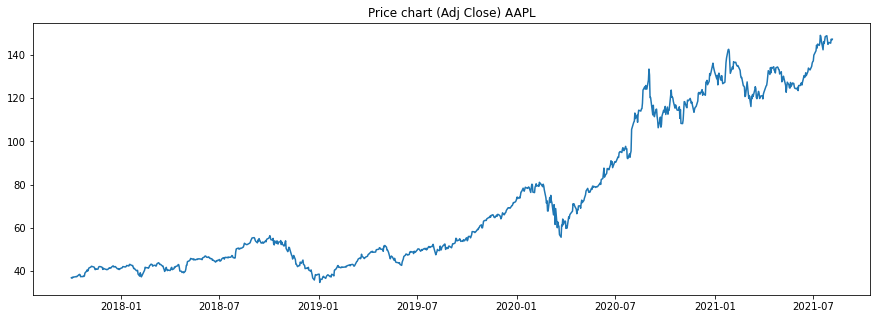

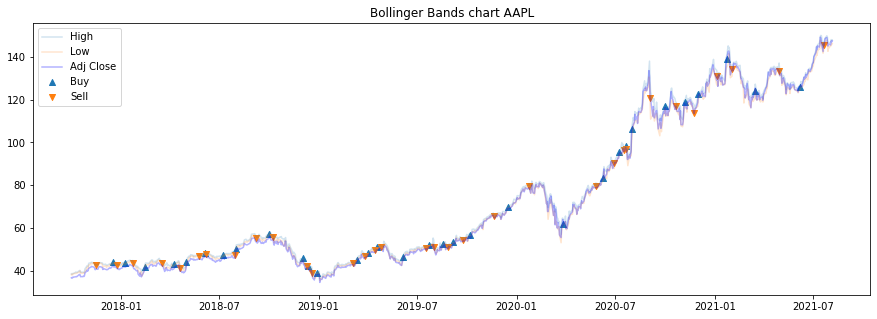

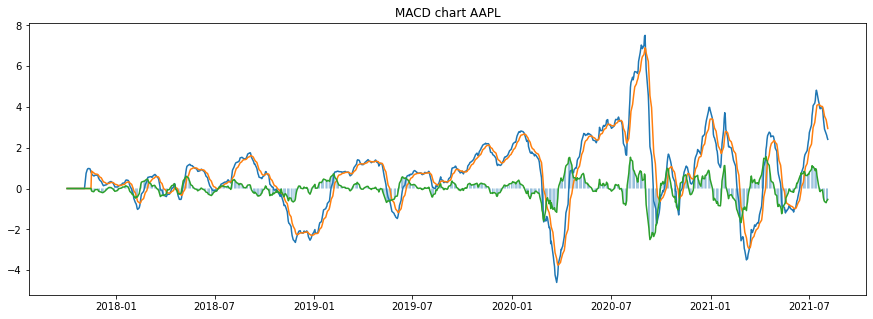

In [62]:
# MAGIC COMPUTATIONAL POWERS THAT PLOT THE CALCULATIONS
plot_signals(df, ticker)

# ANALYZE SIGNALS TOGETHER 

<p> Each signal helps the trader find exit and entry points. Technical Analysis is about using many indicators in conjunction with each other. Notice that when the MACD and other indicators cross the 0 line all indicators confirm the market trend. The MACD however signals potential PROFITABITLY which is what savy investors look for.  it is a common practice to use RSI combined with MACD to find an entry
or exit point in the stock market. When RSI and MACD both indicate the stocks are oversold, it is
more likely to be genuinely the entry point. Similarly, when they both generate overbought
signals, it is probably the true exit point. 
    <li>
    Therefore my project focused more on improving data representation rather than an effective model. 


<!DOCTYPE html>
<html>
<head>
<style>
ul.no-bullets {
  list-style-type: none;
  margin: 0;
  padding: 0;
}
</style>
</head>
<body>

<p>Referenced Material:</p>
<ul>
    <li>Schwager, Jack D.,<i>"Market Wizards"</i>. New York Institute of Finance, 1989. </li>
  <li>Technical Analysis with R: https://bookdown.org/kochiuyu/Technical-Analysis-with-R/evaluating-trading-rules.html</li>
  <li>ML STACK CODE MODEL USING RSI, provided by team: https://tcoil.info/compute-rsi-for-stocks-with-python-relative-strength-index/</li>
  <li>GitHUB Source Code FORECASTING: https://github.com/kennedyCzar/FORECASTING-1.0</li>
    <li> Original Research paper for project: https://arxiv.org/pdf/1903.12258.pdf</li>
    <li>Investopedia: https://www.investopedia.com/ask/answers/122414/what-moving-average-convergence-divergence-macd-formula-and-how-it-calculated.asp</li>
    <li>MACD TI Trading Strategies: <a href="https://www.investopedia.com/trading/macd/">Investopedia: MACD ANALYSIS </a></li>
    <li>Computational Code: <a href="https://tcoil.info/compute-macd-indicator-for-stocks-with-python/">Tcoil TI Analysis Source Code</a></li>
</ul>

<p>Nameless Contributors:</p>
<ul class="no-bullets">
  <li>There are a number of papers that I critically analyzed but did not reference directly. However did still contributed to learning the correct application of the data. The danger of Google rabbit holes is that we move from one subject to another without bookmarking every piece of information that propells our need to understand forward. Still there were countelss hours devoted to reading before any real coding breakthroughs happened. To those overlooked and nameless authors and creators, I tip my hat to you here.</li>
<li>
<p>Proficiencies:</p>
<ul>
    <li>HTML</li>
    <li>R</li>
    <li>Python</li></ul>
    </li>  
</ul>

</body>
</html>
